In [1]:
from matplotlib import pyplot as plt
import scipy as sc
import pandas
import math
import numpy as np
import lmfit
import os
from uncertainties import ufloat
import array_to_latex as atl

In [2]:
plt.rc ('font', size = 15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize = 15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende

In [3]:
def pos(x):
    for i in range(len(data[0])):
        if data[0,i]>=x:
            return i
            break

FitFunktionen

In [4]:
def gaus1fit(von,bis,path,m=1,mmin=0,mmax=2,s=0.2,smax=1000,scale=1e-9,override=False): 
    vonarr = pos(von)
    bisarr = pos(bis)

    model_gaus = lmfit.models.GaussianModel()  
    pars_gaus=model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["center"].set(value=m,min=mmin,max=mmax)
        pars_gaus["sigma"].set(value=1,min=0)
        pars_gaus["amplitude"].set(value=1,min=0)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],yerr=data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],data[1,vonarr:bisarr],yerr=data[2,vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.grid()
    plt.legend()
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())


    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus




def gaus2fit(von,bis,path,override=False,m1=1,s1=1,scale1=1,m2=1,s2=1,scale2=1,m1min=1,m1max=1,m2min=1,m2max=1): 
    vonarr = pos(von)
    bisarr = pos(bis)

    yscale = 1e9
    plt.rc ('font', size =15) # steuert die Standardtextgröße
    plt.rc ('axes', titlesize =15) # Schriftgröße des Titels
    plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
    plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
    plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
    plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende


    model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")

    def guess(data,x):
        params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
        params=model_gaus.make_params()
        for i in params_g1:
            params[i]=params_g1[i]
                    
        params["g2_center"].value=params.get("g1_center").value-1
        params["g2_sigma"].value=params.get("g1_sigma").value*0.5
        params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
        return params

    model_gaus.guess=guess
    pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
    if override:
        #pars_gaus = model_gaus.make_params()
        pars_gaus["g1_center"].set(value=m1,min=m1min,max=m1max)
        pars_gaus["g1_sigma"].set(value=s1)
        pars_gaus["g1_amplitude"].set(value=scale1)
        pars_gaus["g2_center"].set(value=m2,min=m2min,max=m2max)
        pars_gaus["g2_sigma"].set(value=s2)
        pars_gaus["g2_amplitude"].set(value=scale2)


    #Fitten
    out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

    fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)
    plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
    plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")
    

    plt.xlabel('Masse zu Ladungsverhältniss [amu]')
    plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
    plt.grid()
    plt.legend()
    
    plt.savefig('Results/'+str(path)+'.pdf')

    print(out_gaus.fit_report())

    return np.array([np.arange(von,bis,0.01),out_gaus.eval(x=np.arange(von,bis,0.01))]),out_gaus

Daten einlesen und Standartfehler as Fehler der Counts festlegen

<ErrorbarContainer object of 3 artists>

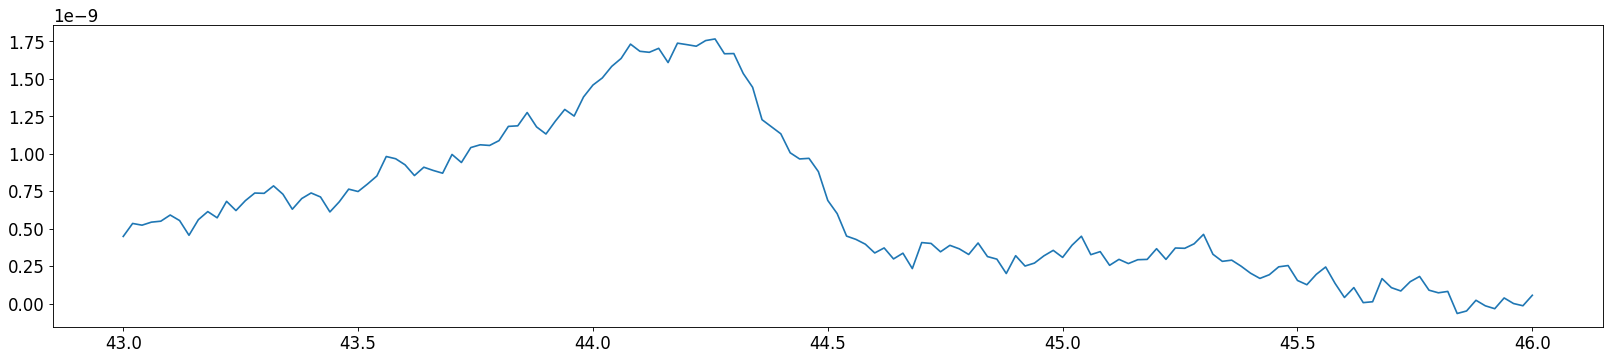

In [5]:
with open('Data/range 43-46 neu.csv', mode='r') as tf:
        dataex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        data = np.zeros((3,len(dataex[3])))
        data[0],data[1] = dataex[3],dataex[4]

with open('Data/restgas.csv', mode='r') as tf:
        datarestex = np.genfromtxt((line.replace(',', '.') for line in tf),delimiter=";",skip_header=21).T
        datarest = np.zeros((3,len(dataex[3])))
        datarest[0],datarest[1] = datarestex[3,pos(43):pos(46)+1],datarestex[4,pos(43):pos(46)+1]



#data
err = list(np.zeros(len(data[1])))
for i in range(len(err)):
    err[i] = ufloat(data[1,i],float(abs(data[1,i])*0.05))

#est
errrest = list(np.zeros(len(datarest[1])))
for i in range(len(errrest)):
    errrest[i] = ufloat(datarest[1,i],float(abs(datarest[1,i])*0.05))

for i in range(len(err)):
        err[i] = err[i]-errrest[i]

for i in range(len(data[1])):
    err[i] = err[i]*data[0,i]/28

for i in range(len(err)):
    data[1,i]=err[i].n
    data[2,i]=err[i].s





v = pos(10)
b = pos(60)

fig = plt.figure(figsize=(25,5),dpi=80,linewidth=50)
plt.errorbar(data[0,v:b],data[1,v:b],label = 'Data')
#plt.vlines(18.6,0,10e-9)

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 94
    # variables        = 6
    chi-square         = 2035.23829
    reduced chi-square = 23.1277078
    Akaike info crit   = 301.056900
    Bayesian info crit = 316.316669
[[Variables]]
    g1_amplitude:  1.1741e-09 +/- 5.6006e-11 (4.77%) (init = 1)
    g1_center:     44.1224902 +/- 0.01654969 (0.04%) (init = 44.2)
    g1_sigma:      0.26747959 +/- 0.01562554 (5.84%) (init = 0.4)
    g2_amplitude:  2.5610e-10 +/- 1.6328e-11 (6.38%) (init = 1)
    g2_center:     45.1169263 +/- 0.02358132 (0.05%) (init = 45.2)
    g2_sigma:      0.28068621 +/- 0.01836302 (6.54%) (init = 0.5)
    g1_fwhm:       0.62986629 +/- 0.03679533 (5.84%) == '2.3548200*g1_sigma'
    g1_height:     1.7511e-09 +/- 9.4463e-11 (5.39%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.66096549 +/- 0.04324161 (6.54%) == 

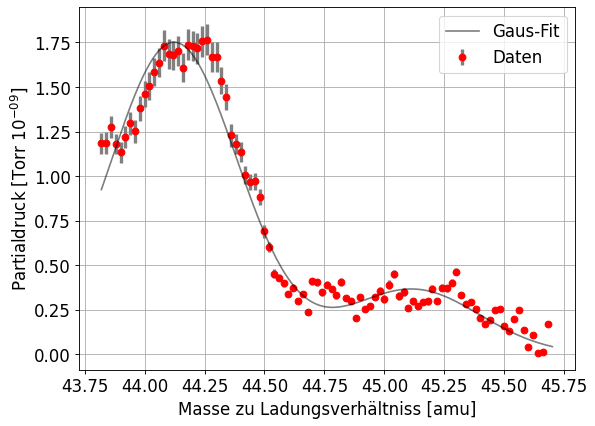

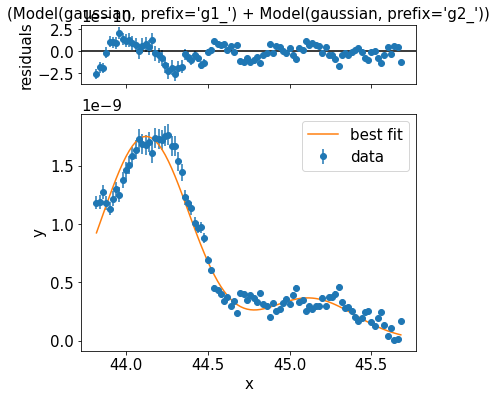

In [61]:
von,bis,path= 43.82,45.7,'range_43-46_44.2'
override=True
 
vonarr = pos(von)
bisarr = pos(bis)
yscale = 1e9
plt.rc ('font', size =15) # steuert die Standardtextgröße
plt.rc ('axes', titlesize =15) # Schriftgröße des Titels
plt.rc ('axes', labelsize = 15) # Schriftgröße der x- und y-Beschriftungen
plt.rc ('xtick', labelsize = 15) #Schriftgröße der x-Tick-Labels
plt.rc ('ytick', labelsize = 15) #Schriftgröße der y-Tick-Labels
plt.rc ('legend', fontsize = 15) #Schriftgröße der Legende
model_gaus=lmfit.models.GaussianModel(prefix="g1_")+lmfit.models.GaussianModel(prefix="g2_")
def guess(data,x):
    params_g1=lmfit.models.GaussianModel(prefix="g1_").guess(data,x)
    params=model_gaus.make_params()
    for i in params_g1:
        params[i]=params_g1[i]
                
    params["g2_center"].value=params.get("g1_center").value-1
    params["g2_sigma"].value=params.get("g1_sigma").value*0.5
    params["g2_amplitude"].value=params.get("g1_amplitude").value*0.3
    return params
model_gaus.guess=guess
pars_gaus = model_gaus.guess(data=data[1,vonarr:bisarr],x=data[0,vonarr:bisarr])
if override:
    pars_gaus = model_gaus.make_params()
    pars_gaus["g1_center"].set(value=44.2)#value=44.2,min=44.1,max=44.5
    pars_gaus["g1_sigma"].set(value=0.4)
    pars_gaus["g1_amplitude"].set()
    pars_gaus["g2_center"].set(value=45.2)#value=45.2,min=45,max=45.4
    pars_gaus["g2_sigma"].set(value=0.5)
    pars_gaus["g2_amplitude"].set()
#Fitten
out_gaus = model_gaus.fit(data[1,vonarr:bisarr],x=data[0,vonarr:bisarr],weights=1/data[2,vonarr:bisarr],params=pars_gaus,nan_policy='propagate')

fig = plt.figure(figsize=(8,6),dpi=80,linewidth=50)

plt.errorbar(data[0,vonarr:bisarr],yscale*data[1,vonarr:bisarr],yerr=yscale*data[2,vonarr:bisarr],fmt='o',ecolor='gray',color='r', elinewidth=3, capsize=0,zorder=5,label="Daten")
plt.plot(np.arange(von,bis,0.01),yscale*out_gaus.eval(x=np.arange(von,bis,0.01)),zorder=10,color='k',linestyle='-',alpha=0.5,label="Gaus-Fit")

plt.xlabel('Masse zu Ladungsverhältniss [amu]')
plt.ylabel('Partialdruck [Torr $10^{'+str(1/yscale).split("e")[1]+'}$]')
plt.grid()
plt.legend()

plt.savefig('Results/'+str(path)+'.pdf')
out_gaus.plot()
print(out_gaus.fit_report())